In [44]:
import bz2
import json
from pprint import pprint
from itertools import combinations
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pytz
import networkx as nx
from networkx.algorithms import community
mpl.rcParams["figure.figsize"] = (10,10)
DATA_FILE = "initial_analysis_data_.csv"
SECOND_DATA_FILE = "graph_analysis_data_.csv"

In [2]:
def load_data(year, month):
    """
    returns: list
        list of dictionaries, where each dictionary contains data about one comment
    """
    print(f"loading data {year} {month} ...", end=" ")
    if month < 10:
        month = "0"+str(month)
    
    filename = f"./reddit_data/{year}/RC_{year}-{month}.bz2"
    with bz2.open(filename, "rt") as f:
        s = [json.loads(x) for x in f.read().split("\n")[:-1]] # last line is and empty line
        print("loaded!")
        return s

In [3]:
def clean_data(data):
    for el in data:
        el["link_id"] = el["link_id"][3:] # eliminate tx_ part of the id
        if el["parent_id"][:3] == "t1_":
            el["parent_id"] = el["parent_id"][3:]
    return data 

In [4]:
# general stats

def get_nr_subreddits(data):
    return np.unique([x["subreddit_id"] for x in data]).shape[0]

def get_nr_commenters(data):
    # including the [deleted] users
    return np.unique([x["author"] for x in data]).shape[0]

def get_nr_posts(data):
    return np.unique([x["link_id"] for x in data]).shape[0]

def get_average_score(data):
    return np.array([x["score"] for x in data]).mean()

def get_deleted_author_count(data):
    return (np.array([x["author"] for x in data]) == "[deleted]").sum()

In [5]:
# helper functions 

def transform_to_dict(data, field):
    d = dict()
    for el in data:
        temp = d.get(el[field], [])
        temp.append(el)
        d[el[field]] = temp
        
    return d

def get_field_av(d):
    count = 0
    nr = 0
    for el in d.values():
        count += len(el)
        nr += 1
    return count / nr

def get_distribution(d):
    lst = []
    for el in d.values():
        lst.append(len(el))
    return lst

In [6]:
# post stats 

def transform_to_post_dict(data):
    return transform_to_dict(data, "link_id")

def get_av_comment_count_on_post(post_dict):
    """Gets the average nr of post count for posts that have at least one comment
    """
    return get_field_av(post_dict)

def get_post_comment_distribution(post_dict):
    return get_distribution(post_dict)

In [7]:
# author stats 

def transform_to_author_dict(data):
    return transform_to_dict(data, "author")

def get_av_comment_count_by_author(author_dict):
    return get_field_av(author_dict)

def get_author_comment_distribution(author_dict):
    return get_distribution(author_dict)


In [8]:
def quick_summary(year, month):
    data = load_data(year, month)
    data = clean_data(data)
    nr_comments = len(data)
    nr_subreddits = get_nr_subreddits(data)
    nr_commenters = get_nr_commenters(data)
    nr_deleted_commenters = get_deleted_author_count(data)
    nr_posts = get_nr_posts(data)
    average_score = get_average_score(data)
    
    post_dict = transform_to_post_dict(data)
    av_comment_count = get_av_comment_count_on_post(post_dict)
    post_distribution = get_post_comment_distribution(post_dict)
    
    author_dict = transform_to_author_dict(data)
    del author_dict["[deleted]"]
    av_author_comments = get_av_comment_count_by_author(author_dict)
    author_distribution = get_author_comment_distribution(author_dict)

    # append to the csv file
    with open(DATA_FILE, "a") as f:
        f.write(f"{year}.{month},{nr_subreddits},{nr_comments},{nr_deleted_commenters},{nr_commenters},"
                f"{av_comment_count},{max(post_distribution)},{av_author_comments},{max(author_distribution)},"
                f"{average_score}\n")

In [9]:
# writing summary data to the DATA_FILE. 
# NB! only set to true if you actually want to run this.
# takes a lot of time
run_quick_summary = False
if run_quick_summary:
    with open(DATA_FILE, "w") as f:
        # writing headings to the data file
        f.write("month,unique_subreddits,unique_comments,nr_deleted_author,unique_commenters,"
                "av_comments_on_post,max_comments_on_post,av_comments_by_author,max_comments_by_author,"
                "av_comment_score\n")
    quick_summary(2005, 12)
    for year in [2006,2007,2008]:
        for month in range(1,13):
            print(year, month)
            quick_summary(year, month)

In [10]:
data = pd.read_csv(DATA_FILE)
months = pd.read_csv(DATA_FILE, usecols=[0], dtype=np.str) # to convert to string 
data.month = months.month
data

,month,unique_subreddits,unique_comments,nr_deleted_author,unique_commenters,av_comments_on_post,max_comments_on_post,av_comments_by_author,max_comments_by_author,av_comment_score
0,2005.12,1,1075,185,394,2.714646,85,2.264631,21,1.562791
1,2006.1,2,3666,893,791,3.125320,145,3.510127,42,1.351337
2,2006.2,18,9095,2386,1464,3.908466,153,4.585783,149,2.122815
3,2006.3,15,13859,4000,1958,4.039347,253,5.037813,125,2.350675
4,2006.4,21,19090,5062,2334,4.790464,336,6.012859,278,2.541383
5,2006.5,21,26859,7019,2698,5.485907,329,7.356322,180,2.930452
6,2006.6,19,29163,8275,3043,4.967297,261,6.866535,251,2.523437
7,2006.7,22,37031,10217,3532,4.857799,276,7.593883,218,2.518025
8,2006.8,24,50559,13912,4750,4.744651,310,7.716782,659,2.629977
9,2006.9,21,50675,14357,4908,4.169752,296,7.401264,453,2.547745


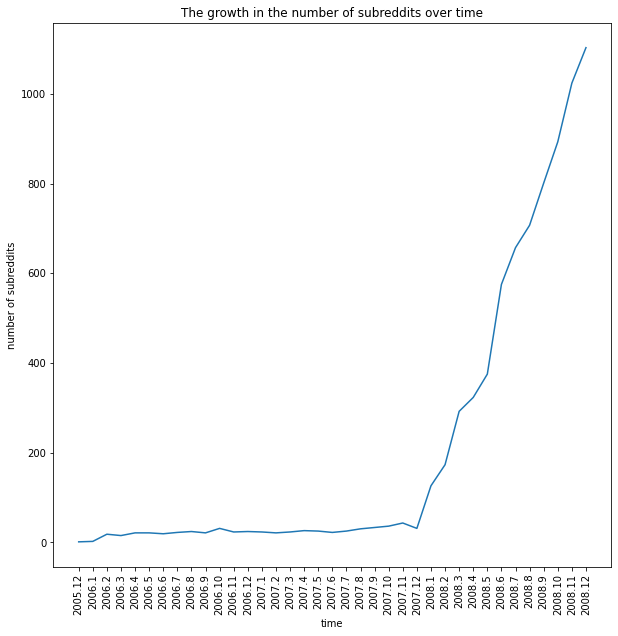

In [11]:
plt.plot(data.month, data.unique_subreddits)
plt.xticks(rotation="vertical")
plt.ylabel("number of subreddits")
plt.xlabel("time")
plt.title("The growth in the number of subreddits over time")
plt.savefig("subreddits.png")

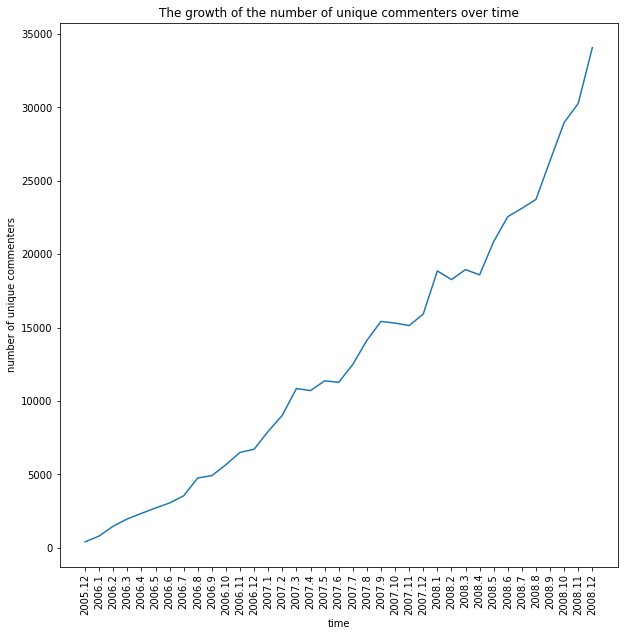

In [12]:
plt.plot(data.month, data.unique_commenters, label="unique commenters")
plt.xticks(rotation="vertical")
plt.ylabel("number of unique commenters")
plt.xlabel("time")
plt.title("The growth of the number of unique commenters over time")
plt.savefig("commenters.png")

### Co-commentator graph creation

In [13]:
# create co-commentator table
# nodes are people, weigths are the nr of posts they have commented, for each subreddit separately
def get_pairs(comments):
    # if solo comment, return empty list
    if len(comments) < 2:
        return []
    pairs = combinations(range(len(comments)), 2)
    data = []
    subreddit = comments[0]["subreddit"]
    for i, j in pairs:
        author1 = comments[i]["author"]
        author2 = comments[j]["author"]
        # ignore the ones where one is deleted
        if author1 == "[deleted]" or author2 == "[deleted]":
            continue
        # ignore the same author
        if author1 == author2: 
            continue
        
        lst = []
        if author1 < author2:
            lst.append(author1)
            lst.append(author2)
        else: 
            lst.append(author2)
            lst.append(author1)
        lst.append(subreddit)
        data.append(lst)
    return data

def get_data(year_month_list):
    data = []
    for year, month in year_month_list:
        temp = load_data(year, month)
        data.extend(clean_data(temp))
    return data

def cocommentator_table(data):
    post_dict = transform_to_post_dict(data)
    df_data = []
    for k, v in post_dict.items():
        df_data.extend(get_pairs(v))
    # print(data)
    df = pd.DataFrame(df_data, columns=["author1", "author2", "subreddit"])
    grouped =  df.groupby(df.columns.tolist(),as_index=False).size()
    grouped2 = grouped.groupby(by=["author1", "author2", "size"])
    return grouped

def cocommentator_table_by_subreddits(data, subreddits):
    df = cocommentator_table(data)
    df = df[df["subreddit"].isin(subreddits)]
    return df

def comments_count_in_subreddits(data, subreddits):
    author_dict = transform_to_author_dict(data)
    new_author_dict = {}
    for author, comments in author_dict.items():
        count = len(list(filter(lambda x: x["subreddit"] in subreddits, comments)))
        if count > 0:
            new_author_dict[author] = count
    try:
        del new_author_dict["[deleted]"]
    except KeyError:
        pass
    return new_author_dict

def cocommentator_graph_in_subreddits(data, subreddits):
    """Get a graph of co-commentors from a list subreddits
    
    returns: the largest connected component of co-commentator graph for the given subreddit
    """
    cocommentators = cocommentator_table_by_subreddits(data, subreddits)
    G = nx.from_pandas_edgelist(cocommentators, 
                            "author1", 
                            "author2", 
                            edge_attr=["subreddit", "size"], 
                            create_using=nx.Graph()
                           )
    # get node labels
    comment_counts = comments_count_in_subreddits(data, subreddits)

    cc_sizes = sorted([len(x) for x in nx.connected_components(G)])
    # print("connected component sizes: ", cc_sizes)
    
    # get the largest subgraph
    try: 
        largest_cc = max(nx.connected_components(G), key=len)
    except ValueError:
        return None
    G_largest = nx.induced_subgraph(G, largest_cc)

    # unfreeze the graph 
    G_largest = nx.Graph(G_largest)
    for el in G_largest.nodes:
        G_largest.add_node(el, comments=comment_counts[el])
        
    return G_largest

def net_prop_dict(G):
    prop_dict = {}
    if G is not None:
        prop_dict['no_of_nodes'] = nx.number_of_nodes(G)
        prop_dict['no_of_edges'] = nx.number_of_edges(G)
        if nx.is_connected(G):
            prop_dict['average_shortest_path_length'] = nx.average_shortest_path_length(G)
            prop_dict['diameter'] = nx.diameter(G)
        prop_dict['transitivity'] = nx.transitivity(G)
        prop_dict['average_clustering'] = nx.average_clustering(G)   
        prop_dict['edge_density'] = nx.classes.function.density(G)
        prop_dict['average_degree'] = np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)
        prop_dict['total_triangles'] = np.array(list(nx.triangles(G).values())).sum()
        prop_dict['number_connected_components'] = nx.algorithms.components.number_connected_components(G)
    return prop_dict

In [14]:
def graph_info(yml):
    data = get_data(yml)
    unique_subreddits = np.unique([x["subreddit"] for x in data])
    
    file_data = []
    
    for subreddit in unique_subreddits:
        print(subreddit, end=" ")
        G_largest = cocommentator_graph_in_subreddits(data, [subreddit])
        prop_dict = net_prop_dict(G_largest)
        d = dict()
        d[subreddit] = prop_dict
        file_data.append(d)
    print()
    return file_data
  
def write_to_file(yml): 
    with open(SECOND_DATA_FILE, "w") as f:
        f.write(
                f"year,month,subreddit,nr_nodes,nr_edges,len_av_shortest_path,diameter,transitivity,"
                f"av_clustering,edge_density,av_degree,total_triangles,nr_connected_components\n"
               )
        for ym in yml:
            print("****"*24)
            print(ym)
            file_data = graph_info([ym])
            for subreddit_dict in file_data:
                for subreddit, value_dict in subreddit_dict.items():
                    s = f"{ym[0]},{ym[1]},{subreddit}"
                    for value in value_dict.values():
                        s += f",{value}"
                    f.write(s+"\n")

In [15]:
run_graph_summary = False
if run_graph_summary: 
    yml = [(2005, 12)]
    for y in [2006, 2007, 2008]:
        for m in range(1, 13):
            yml.append((y, m))

    write_to_file(yml)

In [16]:
data = pd.read_csv("graph_analysis_data_.csv").dropna()
data

,year,month,subreddit,nr_nodes,nr_edges,len_av_shortest_path,diameter,transitivity,av_clustering,edge_density,av_degree,total_triangles,nr_connected_components
0,2005,12,reddit.com,287.0,2774.0,2.934992,8.0,0.772001,0.732248,0.067591,19.331010,98373.0,1.0
2,2006,1,reddit.com,590.0,6657.0,2.615545,6.0,0.469636,0.703888,0.038313,22.566102,170091.0,1.0
3,2006,2,de,4.0,3.0,1.500000,2.0,0.000000,0.000000,0.500000,1.500000,0.0,1.0
6,2006,2,features,46.0,221.0,2.223188,5.0,0.830009,0.662623,0.213527,9.608696,2622.0,1.0
7,2006,2,fr,2.0,1.0,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007,10,programming,3128.0,156933.0,2.198316,5.0,0.308940,0.756028,0.032089,100.340793,12654576.0,1.0
496,2007,10,reddit.com,9153.0,1240388.0,2.296103,10.0,0.299878,0.691247,0.029615,271.034196,338487120.0,1.0
497,2007,10,request,3.0,3.0,1.000000,1.0,1.000000,1.000000,1.000000,2.000000,3.0,1.0
499,2007,10,science,2301.0,109090.0,2.264673,6.0,0.494120,0.792240,0.041226,94.819644,11360961.0,1.0


### Subreddit comparison

In [17]:
def get_ym_index(data, year, month):
    gp = data.groupby(["year", "month"], as_index = False).size()
    return gp[(gp.year == year) & (gp.month == month)].index[0]
    
def get_month(ym):
    return str(ym[0])+"."+str(ym[1])
    
def get_months(data):
    gp = data.groupby(["year", "month"], as_index = False).size()
    months = []
    for i, el in gp.iterrows():
        months.append(""+str(el.year)+"."+str(el.month))
    return months

def analyze_subreddit(data, subreddit):
    """Returns the list of nr_nodes by month"""
    subreddit_data = data[data.subreddit == subreddit]
    nr_nodes_list = np.zeros(23)

    for i, el in subreddit_data.iterrows():
        nr_nodes_list[get_ym_index(data, el.year, el.month)] = el.nr_nodes
    
    return nr_nodes_list
    
science = analyze_subreddit(data, "science")
programming = analyze_subreddit(data, "programming")
reddit = analyze_subreddit(data, "reddit.com")
months = get_months(data)

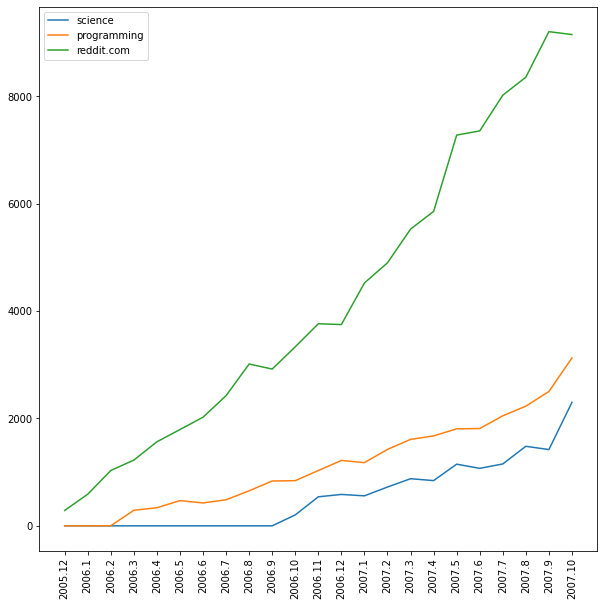

In [18]:
plt.plot(months, science, label="science")
plt.plot(months, programming, label="programming")
plt.plot(months, reddit, label="reddit.com")
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

### Monthly evolution

In [19]:
yml = [(2005, 12)]
for y in [2006, 2007]:
    for m in range(1, 13):
        yml.append((y, m))
        if y == 2007 and m == 3:
            break

def get_ym_start(ym):
    return datetime(ym[0], ym[1], 1, tzinfo=pytz.utc)

def get_ym_end(ym):
    if ym[1] in [4,6,9,11]:
        return datetime(ym[0],ym[1],30,23,59,59, tzinfo=pytz.utc)
    if ym[1] == 2:
        # we don't have leap years
        return datetime(ym[0],ym[1],28,23,59,59, tzinfo=pytz.utc)
    return datetime(ym[0],ym[1],31,23,59,59, tzinfo=pytz.utc)

# yml = yml[:2]
all_datas = get_data(yml)
# should be sorted, but just in case
all_datas.sort(key=lambda x: x["created_utc"])

def get_data_for_yml(yml):
    # get all comments within range of year and month
    first = yml
    last = yml
    if type(yml) == type([]):
        first = yml[0]
        last = yml[-1]
    start = int(get_ym_start(first).timestamp())
    stop = int(get_ym_end(last).timestamp())
    
    return list(filter(lambda x: x["created_utc"] > start and x["created_utc"] < stop, all_datas))

loading data 2005 12 ... loaded!
loading data 2006 1 ... loaded!
loading data 2006 2 ... loaded!
loading data 2006 3 ... loaded!
loading data 2006 4 ... loaded!
loading data 2006 5 ... loaded!
loading data 2006 6 ... loaded!
loading data 2006 7 ... loaded!
loading data 2006 8 ... loaded!
loading data 2006 9 ... loaded!
loading data 2006 10 ... loaded!
loading data 2006 11 ... loaded!
loading data 2006 12 ... loaded!
loading data 2007 1 ... loaded!
loading data 2007 2 ... loaded!
loading data 2007 3 ... loaded!


In [20]:
def get_graph_of_yml(yml, subreddits):
    data = get_data_for_yml(yml)
    G_largest = cocommentator_graph_in_subreddits(data, subreddits)
    return G_largest

def get_perc_of_new(yml, index, subreddits_old, subreddits_new):
    G_old = get_graph_of_yml(yml[:index-1], subreddits_old)
    G_new = get_graph_of_yml(yml[index-1], subreddits_new)
    if G_old is None or G_new is None:
        return yml[index-1:index][0], 0, 0
    
    s_old = set(G_old.nodes)
    s_new = set(G_new.nodes)
    intersection = s_old & s_new
    perc_of_new = len(intersection)/len(s_new)
    perc_of_old_recomment = len(intersection)/len(s_old)
    return yml[index-1:index][0], perc_of_new, perc_of_old_recomment

def get_percentages_over_yml(yml):
    all_subreddits = ["reddit.com", "programming", "science"]
    d_compared_to_all = dict()
    d_compared_to_itself = dict()

    for subreddit in all_subreddits:
        d_compared_to_all[subreddit] = []
        d_compared_to_itself[subreddit] = []
    
    for i in range(2, len(yml)+1):
        print(f"{i-1}/{len(yml)-1} {yml[:i-1]}")
        for subreddit in all_subreddits:
            d_compared_to_all[subreddit].append(get_perc_of_new(yml, i, all_subreddits, [subreddit]))
            d_compared_to_itself[subreddit].append(get_perc_of_new(yml, i, [subreddit], [subreddit]))
            
    return d_compared_to_all, d_compared_to_itself

get_percentages = False
if get_percentages:
    percentages = get_percentages_over_yml(yml)

In [21]:
save_perc_file = "percentages.csv"
if get_percentages:
    all_perc = percentages[0]
    self_perc = percentages[1]
    def preprocess_for_df(subreddit, value, is_all):
        # is_all -- whether compared to all or just with itself
        is_all_column = np.full(len(value), is_all)
        subreddit_column = np.full(len(value), subreddit)
        year_column = np.array([x[0][0] for x in value])
        month_column = np.array([x[0][1] for x in value])
        perc_of_new = np.array([x[1] for x in value])
        perc_of_old = np.array([x[2] for x in value])
        
        return {
            "compared_to_all": is_all_column,
            "subreddit": subreddit_column,
            "year": year_column,
            "month": month_column,
            "perc_of_new": perc_of_new,
            "perc_of_old": perc_of_old
        }
        # return np.column_stack((is_all_column, subreddit_column, year_column, month_column, perc_of_new, perc_of_new))

    d = dict()
    for k, v in all_perc.items():
        temp_dict = preprocess_for_df(k, v, True)
        if len(d.keys()) == 0:
            d = temp_dict
        else:
            for key in d.keys():
                d[key] = np.append(d[key], temp_dict[key])

    for k, v in self_perc.items():
        temp_dict = preprocess_for_df(k, v, False)
        for key in d.keys():
            d[key] = np.append(d[key], temp_dict[key])

    df = pd.DataFrame(d)
    df.to_csv(save_perc_file, index=False)

perc_df = pd.read_csv(save_perc_file)
perc_df.head()

,compared_to_all,subreddit,year,month,perc_of_new,perc_of_old
0,True,reddit.com,2006,1,0.257627,0.529617
1,True,reddit.com,2006,2,0.348206,0.478029
2,True,reddit.com,2006,3,0.495510,0.422114
3,True,reddit.com,2006,4,0.536398,0.391608
4,True,reddit.com,2006,5,0.581382,0.354039


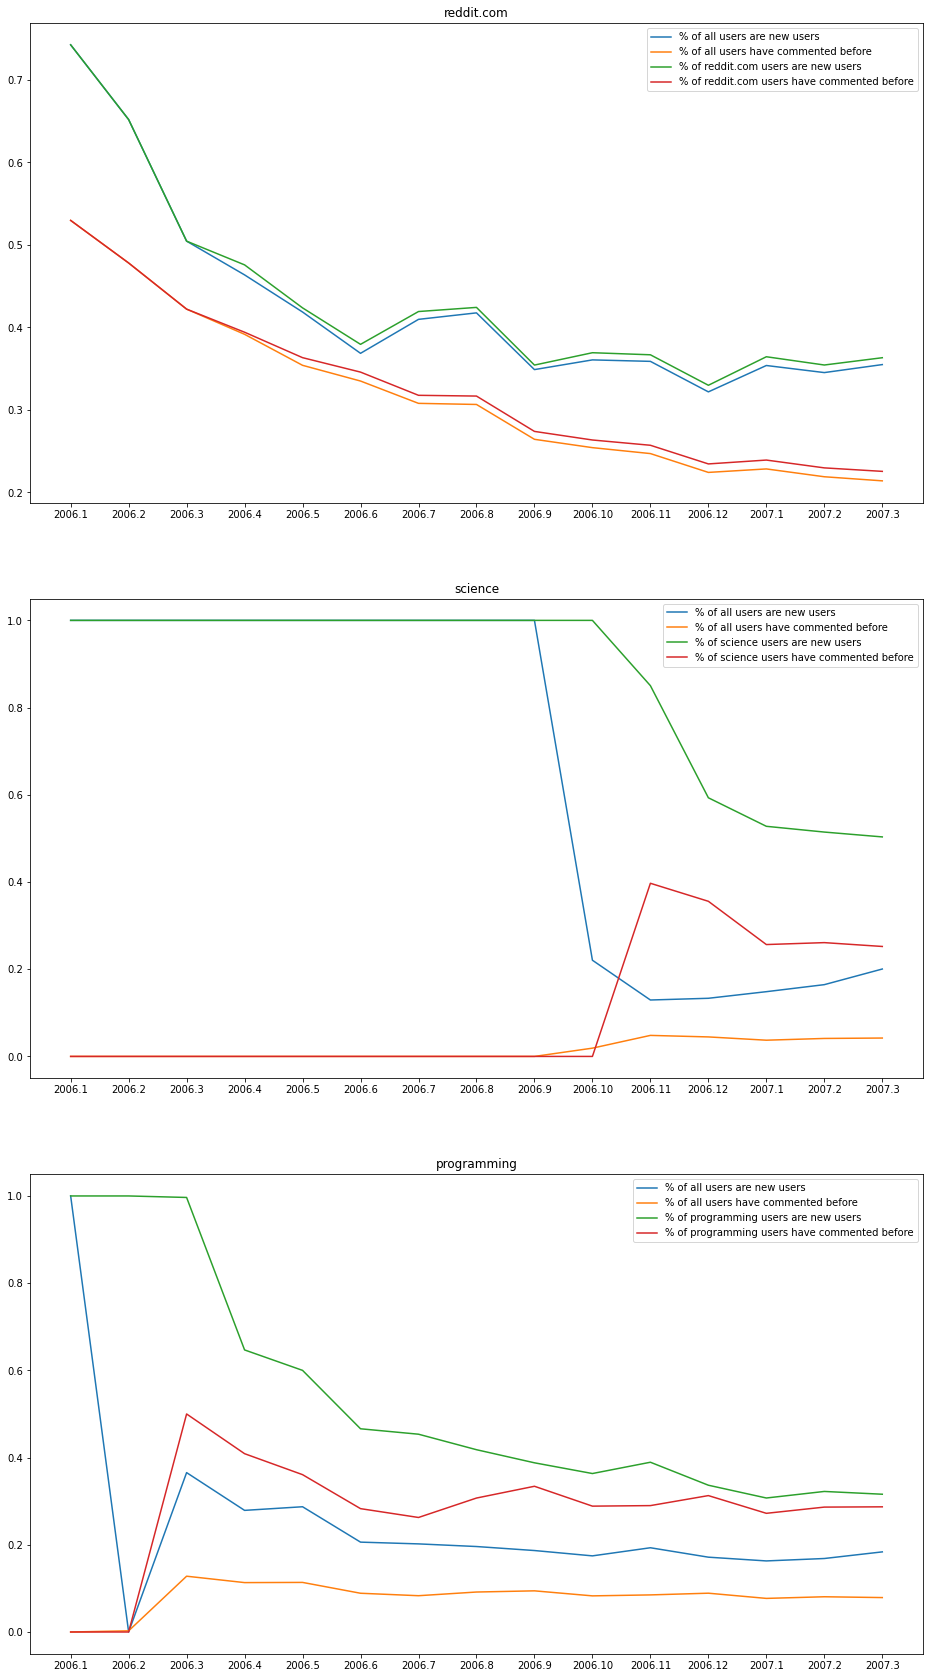

In [27]:
def plot_percentages(ax, df, is_all, subreddit):
    data = df[(df.compared_to_all == is_all) & (df.subreddit == subreddit)]
    months = get_months(data)
    label_base = f"% of "
    if is_all:
        s = "all users "
    else:
        s = f"{subreddit} users "
    label_base += s
    label_new = label_base + "are new users"
    label_old = label_base + "have commented before"
    
    ax.plot(months, 1 - data.perc_of_new, label=label_new)
    ax.plot(months, data.perc_of_old, label=label_old)
    ax.set_title(subreddit)
fig, axs = plt.subplots(3,1, figsize=(16,30))
for boolean in [True, False]:
    subreddits = ["reddit.com", "science", "programming"]
    for i in range(3):
        plot_percentages(axs[i], perc_df, boolean, subreddits[i])
        
for i in range(3):
    axs[i].legend()
plt.show()

### Visualization

In [131]:
G = get_graph_of_yml((2006,3), ["programming"])

In [90]:
len(G.nodes)

1305

In [132]:
# communities = list(community.label_propagation_communities(G))
communities = list(community.greedy_modularity_communities(G))
# communities.sort(key=len, reverse=True)

In [133]:
def get_colors(communities, nodes):
    node_colors = dict()
    # sorting so that larger communities get different colors
    communities.sort(key=len, reverse=True)
    c1 = [communities[i] for i in range(len(communities)) if i%2==0]
    c2 = [communities[i] for i in range(len(communities)) if i%2==1]
    c1.sort(key=len, reverse=True)
    c2.sort(key=len, reverse=False)
    c1.extend(c2)
    communities = c1
    n_communities = len(communities)-1
    print(len(communities))
    for el in communities:
        print(len(el), end=" ")
    for i, community in enumerate(communities):
        for node in community: 
            node_colors[node] = i/n_communities
    colors = []
    for node in nodes:
        colors.append(node_colors[node])
    return colors

In [134]:
colors = get_colors(communities, G.nodes)

10
55 39 30 28 7 3 23 29 34 42 

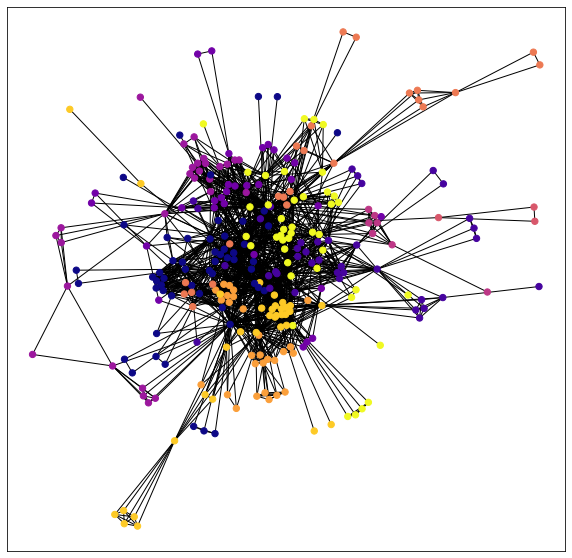

In [136]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,  node_size=40, node_color=colors, cmap="plasma")
nx.draw_networkx_edges(G, pos)

In [137]:
eigenvector_centralities = nx.eigenvector_centrality(G)

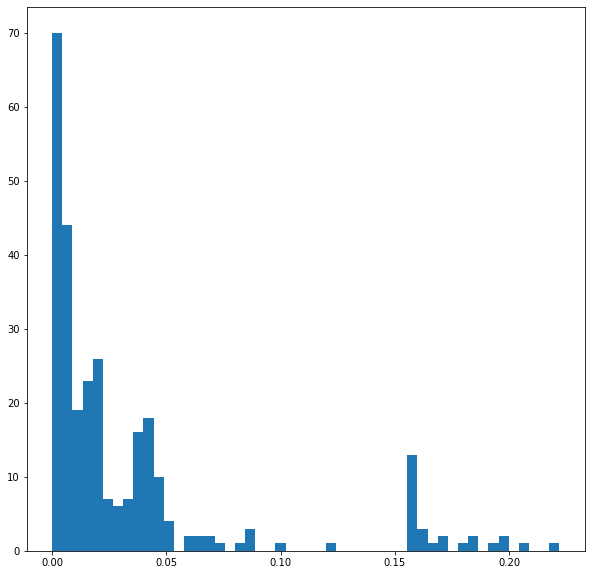

In [139]:
plt.hist(eigenvector_centralities.values(), bins=50)
plt.show()

In [140]:
pagerank = nx.pagerank(G)

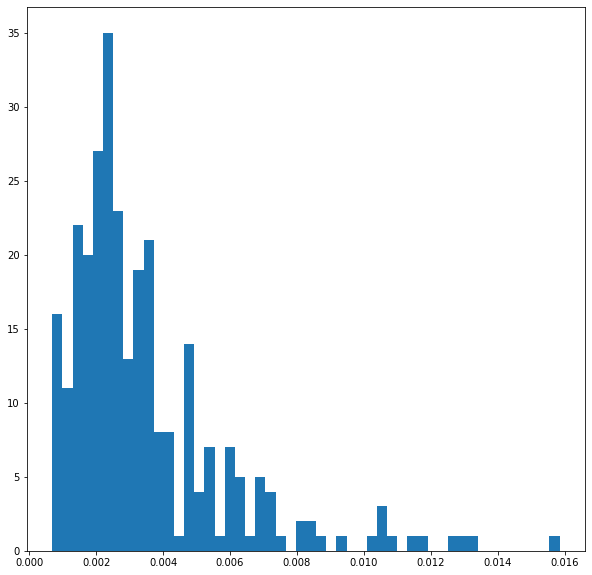

In [141]:
plt.hist(pagerank.values(), bins=50)
plt.show()

In [142]:
def get_overlap(eigen, page, k, printout=False):
    eigen_sorted = sorted(eigen, key=eigen.get, reverse=True)
    page_sorted = sorted(page, key=page.get, reverse=True)
    if printout:
        for i in range(10):
            print("****"*24)
            print(eigen_sorted[i], eigen[eigen_sorted[i]])
            print(page_sorted[i], page[page_sorted[i]])
    
    topk_eigen = set(eigen_sorted[:k])
    topk_page = set(page_sorted[:k])
    union = len(topk_eigen & topk_page)
    return union/k
    
def get_percentage_cutoff(d, cutoff):
    values = sorted(d, key=d.get)
    n = int(len(values)*cutoff)
    return d[values[n]]

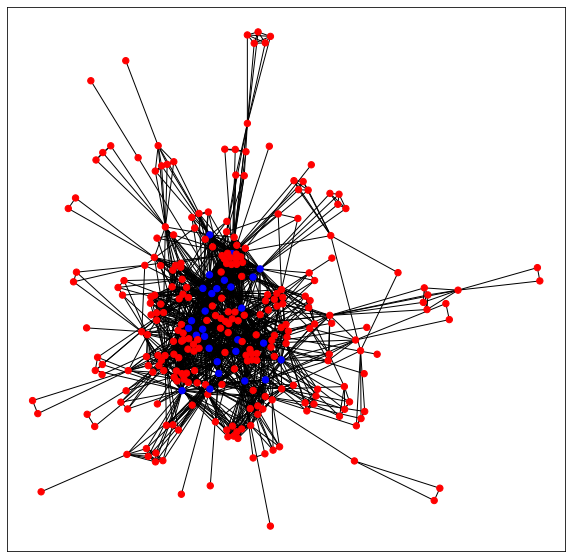

In [143]:
colors = ["red"]*len(G.nodes)
cutoff = get_percentage_cutoff(pagerank, 0.9)

for i, node in enumerate(G.nodes):
    if pagerank[node] > cutoff:
        colors[i] = "blue"
        
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,  node_size=40, node_color=colors, cmap="plasma")
nx.draw_networkx_edges(G, pos)

### Common edges

### Plan

1. How many of the people are commenting on different subreddits
2. How many of the nodes are in the next month as well (in %) and how many are new
3. Visualization of one subreddit network 
4. How many of the links are between the different subreddits 
5. Train link predictor on one and try to predict in another 